<a href="https://colab.research.google.com/github/smartaces/deepseek_colab_quickstart/blob/main/DeepSeek_API_Multi_Turn_R1_Reasoning_Chat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DeepSeek API QuickStart**

This Notebook helps you experiment with DeepSeek's chat and R1 reasoning AI model.

Full instructions on how to use this are provided below.

**Connect with Me**

If you like this notebook or in any way found it helpful, feel free to connect with me on LinkedIn here: https://www.linkedin.com/in/james-bentley-1b329214/

## **Installs**


As per the documentation here: https://api-docs.deepseek.com/

DeepSeek uses the same API structure as OpenAI

There are just a couple of modifications, to get started you pip install OpenAI

In [ ]:
!pip install -U openai --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.1/456.1 kB 7.7 MB/s eta 0:00:00


## **API Key Setup**

You will need to sign up for a DeepSeek API key here: https://www.deepseek.com/

Make sure you have set your DeepSeek API in Key in Colab secrets naming it: **DeepSeek_API**

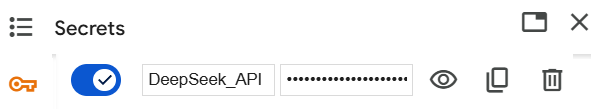

In [ ]:
#setup and load your openai key
import os
from openai import OpenAI
from google.colab import userdata

# Retrieve the DeepSeek key from the user
DeepSeek_API = userdata.get('DeepSeek_API')

## **Quick Test To Check Model Names**

This should confirm your API connection is working by giving you a response of available models...

In [ ]:
from openai import OpenAI

# for backward compatibility, you can still use `https://api.deepseek.com/v1` as `base_url`.
client = OpenAI(api_key=DeepSeek_API, base_url="https://api.deepseek.com")
print(client.models.list())

SyncPage[Model](data=[Model(id='deepseek-chat', created=None, object='model', owned_by='deepseek'), Model(id='deepseek-reasoner', created=None, object='model', owned_by='deepseek')], object='list')


# **DeepSeek Streaming R1 Reasoning Multi-Turn Chat**

This is a basic chat functionality that stores up to six rolling messages for you to chat with DeepSeek R1. This is a good way to experience the full size model, and also gives a base for you to start testing and building your own code.

In [ ]:
#some styling
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
from openai import OpenAI
from google.colab import userdata

# Initialize client
client = OpenAI(
    api_key=userdata.get('DeepSeek_API'),
    base_url="https://api.deepseek.com"
)

print("Chat with DeepSeek Reasoner started. Type 'quit' to exit.")
print("This chat will show both the reasoning process and final answer.")
print("-" * 70)

# Initialize conversation history
conversation_history = []

def get_streaming_response(messages):
    """Get a streaming response from the model while maintaining conversation history"""
    try:
        # Get streaming response
        response = client.chat.completions.create(
            model="deepseek-reasoner",
            messages=messages,
            stream=True
        )

        # Initialize content collectors
        reasoning_content = ""
        final_content = ""
        has_started_content = False
        is_in_reasoning = True  # Track whether we're still in the reasoning phase

        # Print streaming response with clear separation
        print("\nReasoning Process:")

        for chunk in response:
            # Check for finish_reason
            if hasattr(chunk.choices[0], 'finish_reason') and chunk.choices[0].finish_reason:
                if is_in_reasoning:
                    is_in_reasoning = False
                    print("\nFinal Answer:")
                continue

            # Handle reasoning content
            if hasattr(chunk.choices[0].delta, 'reasoning_content'):
                new_text = chunk.choices[0].delta.reasoning_content
                if new_text is not None:
                    reasoning_content += new_text
                    print(new_text, end='', flush=True)

            # Handle final content
            if hasattr(chunk.choices[0].delta, 'content'):
                new_text = chunk.choices[0].delta.content
                if new_text is not None:
                    if not has_started_content:
                        if is_in_reasoning:
                            print("\n\nFinal Answer:\n")
                            is_in_reasoning = False
                        has_started_content = True
                    final_content += new_text
                    print(new_text, end='', flush=True)

        # Ensure we have both parts
        if not final_content.strip():
            # Try a non-streaming request to get the content
            non_stream_response = client.chat.completions.create(
                model="deepseek-reasoner",
                messages=messages,
                stream=False
            )
            final_content = non_stream_response.choices[0].message.content
            if final_content and not has_started_content:
                print("\n\nFinal Answer:")
                print(final_content)

        return reasoning_content.strip(), final_content.strip()

    except Exception as e:
        print(f"\nError occurred: {str(e)}")
        return None, None

while True:
    # Get user input
    user_input = input("\nYou: ")

    if user_input.lower() in ['quit', 'exit', 'q']:
        print("\nChat ended.")
        break

    try:
        # Add user's message to history
        conversation_history.append({"role": "user", "content": user_input})

        # Create message array with history
        current_messages = conversation_history[-6:]  # Keep last 6 messages (3 exchanges)

        # Get response
        print("\nDeepSeek is thinking...")
        print("-" * 70)

        reasoning, answer = get_streaming_response(current_messages)

        if reasoning is not None and answer is not None:
            # Add assistant's response to history (only the final answer, not reasoning)
            conversation_history.append({"role": "assistant", "content": answer})
        else:
            print("\nFailed to get a response. Clearing conversation history and starting fresh.")
            conversation_history = []

        print("\n" + "-" * 70)

    except Exception as e:
        print(f"\nError occurred: {str(e)}")
        print("Clearing conversation history and starting fresh.")
        conversation_history = []
        print("-" * 70)

Chat with DeepSeek Reasoner started. Type 'quit' to exit.
This chat will show both the reasoning process and final answer.
----------------------------------------------------------------------

You: hello

DeepSeek is thinking...
----------------------------------------------------------------------

Reasoning Process:
Okay, the user just said "hello". I need to respond in a friendly and welcoming manner.

First, I should greet them back. Maybe "Hello! How can I assist you today?" That sounds good.

Wait, I should check if there's any specific context or previous messages. The history shows this is the first message, so no prior context. Just a simple hello.

Make sure the response is open-ended to encourage them to ask for help. Avoid being too robotic. Keep it natural.

Maybe add a smiley emoji to make it more friendly. But the example response didn't use one. Hmm, perhaps better to stick without it unless the user does first.

Alright, go with "Hello! How can I assist you today?" T

KeyboardInterrupt: Interrupted by user

# **DeepSeek Non-Reasoning Multi-Turn Chat**

Below is the code to run a simple mult-chat conversation with the DeepSeek chat model, note that this is not the R1 reasoning model, it is (as of 27/01/2025) running from their V3 model, which is not a reasoning model.

In [ ]:
from openai import OpenAI
from google.colab import userdata

# Initialize client
client = OpenAI(
    api_key=userdata.get('DeepSeek_API'),
    base_url="https://api.deepseek.com"
)

# Initialize conversation with system message
messages = [
    {"role": "system", "content": "You are a helpful assistant"}
]

print("Chat started. Type 'quit' to exit.")
print("-" * 50)

while True:
    user_input = input("\nYou: ")

    if user_input.lower() in ['quit', 'exit', 'q']:
        print("\nChat ended.")
        break

    # Add user message to conversation
    messages.append({"role": "user", "content": user_input})

    # Get response
    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=messages,
        stream=False
    )

    # Add assistant's response to conversation history
    assistant_message = response.choices[0].message
    messages.append(assistant_message)

    # Print assistant's response
    print("\nAssistant:", assistant_message.content)
    print("-" * 50)

Chat started. Type 'quit' to exit.
--------------------------------------------------

You: hello

Assistant: Hello! How can I assist you today? 😊
--------------------------------------------------

You: whats gwanin

Assistant: "Wagwan" is a casual greeting in Jamaican Patois, short for "What's going on?" or "What's happening?" It's a friendly way to ask how someone is doing or what's up. So, wagwan with you? 😊
--------------------------------------------------


KeyboardInterrupt: Interrupted by user